In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster
from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram
from sklearn import preprocessing
from sklearn import decomposition
import scipy.stats as st
from scipy.stats import ks_2samp
# Student's t-test
from scipy.stats import ttest_ind
import matplotlib.lines as mlines
from scipy.stats import shapiro

#Importation du fichier population mondiale par pays de 2012 à 2018

In [2]:
temp = pd.read_csv("pop2k122k18.csv")#2012 a 2018
temp.head(2)

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2012,2012,1000 personnes,31161.376,X,Sources internationales sûres,NaN
1,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2018,2018,1000 personnes,37171.921,X,Sources internationales sûres,NaN


In [3]:
pop = pd.pivot_table(temp, values='Valeur', index=['Zone'],  columns='Année', aggfunc=sum)
del temp
pop

Année,2012,2018
Zone,,
Afghanistan,31161.376,37171.921
Afrique du Sud,52832.658,57792.518
Albanie,2914.096,2882.740
Algérie,37383.895,42228.408
Allemagne,80972.628,83124.418
...,...,...
Îles Salomon,556.063,652.857
Îles Turques et Caïques,34.066,37.665
Îles Vierges américaines,105.534,104.680


#Création de la colonne evod representant la croissance demographique en pourcentage de 2012 à 2018 et soustraction des colonnes inutiles

In [4]:
pop['evod'] = round(((pop[2018] / pop[2012])*100-100),2)
pop=pop.reset_index()
pop.sort_values(by='Zone')
pop=pop.drop([2012 , 2018], axis=1)
pop

Année,Zone,evod
0,Afghanistan,19.29
1,Afrique du Sud,9.39
2,Albanie,-1.08
3,Algérie,12.96
4,Allemagne,2.66
...,...,...
232,Îles Salomon,17.41
233,Îles Turques et Caïques,10.56
234,Îles Vierges américaines,-0.81
235,Îles Vierges britanniques,4.02


#Importation du fichier contenant les donnees alimentaires nécessaires (2017 : derniere année disponible)

In [5]:
# et creation du fichier prot contenant total prot & total kcal, veg & ani
temp2 = pd.read_csv("prot.csv")
prot = pd.pivot_table(temp2, values='Valeur', index=['Zone'],  columns='Élément', aggfunc=sum)
prot=prot.reset_index()
prot.rename(columns={"Disponibilité alimentaire (Kcal/personne/jour)":"Disp_alim_tot_(Kcal/pers/j)"},inplace=True)
prot.rename(columns={"Disponibilité de protéines en quantité (g/personne/jour)":"Disp_prot_tot_(g/pers/j)"},inplace=True)
prot

Élément,Zone,Disp_alim_tot_(Kcal/pers/j),Disp_prot_tot_(g/pers/j)
0,Afghanistan,2000.0,54.09
1,Afrique du Sud,2994.0,83.41
2,Albanie,3399.0,119.55
3,Algérie,3349.0,92.92
4,Allemagne,3556.0,104.21
...,...,...,...
168,Émirats arabes unis,3366.0,107.34
169,Équateur,2586.0,65.78
170,États-Unis d'Amérique,3766.0,113.73
171,Éthiopie,2303.0,65.65


In [6]:
#creation du fichier prota contenant prot & kcal animal
temp3 = temp2[temp2["Produit"] == "Produits Animaux"]
prota = pd.pivot_table(temp3, values='Valeur', index=['Zone'],  columns='Élément', aggfunc=sum)
prota.rename(columns={"Disponibilité alimentaire (Kcal/personne/jour)":"Disp_alim_ani_(Kcal/pers/j)"},inplace=True)
prota.rename(columns={"Disponibilité de protéines en quantité (g/personne/jour)":"Disp_prot_ani_(g/pers/j)"},inplace=True)
prota

Élément,Disp_alim_ani_(Kcal/pers/j),Disp_prot_ani_(g/pers/j)
Zone,,
Afghanistan,191.0,10.55
Afrique du Sud,456.0,34.56
Albanie,1094.0,66.34
Algérie,404.0,25.71
Allemagne,1093.0,63.08
...,...,...
Émirats arabes unis,596.0,43.83
Équateur,504.0,29.94
États-Unis d'Amérique,1026.0,73.87


#Création du dataframe data contenant les informations dont nous avons besoin

In [7]:
del temp2
del temp3
prota=prota.reset_index()
data = pd.merge(pop, prot, on=["Zone"],how="outer", ).copy()
data = pd.merge(data, prota, on=["Zone"],how="outer", ).copy()
data=data.drop(['Disp_alim_ani_(Kcal/pers/j)'], axis=1)#soustraction de la colonne inutile
data['ratio_p_ani']=round((data['Disp_prot_ani_(g/pers/j)']/data['Disp_prot_tot_(g/pers/j)']),2)#creation de la colonne ratio proteines animales
data=data.drop(['Disp_prot_ani_(g/pers/j)'], axis=1)#soustraction de la colonne inutile
data = data[data["Zone"] != "Chine"]#retrait du doublon avec les 4 regions qui la composent
data = data.dropna()#elimination des nan
data.sort_values(by='ratio_p_ani')#une idee des ratio extremes

,Zone,evod,Disp_alim_tot_(Kcal/pers/j),Disp_prot_tot_(g/pers/j),ratio_p_ani
224,Éthiopie,17.79,2303.0,65.65,0.09
134,Nigéria,17.13,2464.0,55.92,0.13
32,Burkina Faso,19.19,2719.0,76.13,0.14
133,Niger,26.12,2579.0,81.89,0.15
159,Rwanda,16.61,2215.0,59.24,0.15
...,...,...,...,...,...
43,Chine - RAS de Macao,11.98,3002.0,100.46,0.67
125,Mongolie,12.23,2371.0,82.39,0.68
17,Bahamas,6.07,2043.0,61.47,0.68
91,Islande,3.40,3627.0,141.01,0.72


#Création d'un dataframe data_pib integrant le du pib par habitant en USD pour l'année 2017(derniere annés connue)

In [8]:
##temp = pd.read_csv("/content/drive/My Drive/Colab Notebooks/P5TP/pibpa_usd2017.csv")
temp = pd.read_csv("pibpa_usd2017.csv")
temp.rename(columns={"Valeur":"pib_pa"},inplace=True)
temp = temp[["Zone","pib_pa"]]
data = pd.merge(data, temp, on=["Zone"],how="inner" )
del temp
data_pib = data.copy()
data = data[['Zone', 'Disp_alim_tot_(Kcal/pers/j)', 'Disp_prot_tot_(g/pers/j)', 'ratio_p_ani', 'evod']]
data.set_index('Zone', inplace=True)
data

,Disp_alim_tot_(Kcal/pers/j),Disp_prot_tot_(g/pers/j),ratio_p_ani,evod
Zone,,,,
Afghanistan,2000.0,54.09,0.20,19.29
Afrique du Sud,2994.0,83.41,0.41,9.39
Albanie,3399.0,119.55,0.55,-1.08
Algérie,3349.0,92.92,0.28,12.96
Allemagne,3556.0,104.21,0.61,2.66
...,...,...,...,...
Émirats arabes unis,3366.0,107.34,0.41,5.35
Équateur,2586.0,65.78,0.46,10.41
États-Unis d'Amérique,3766.0,113.73,0.65,4.16


#Intégration des fonctons utiles

In [9]:
#fonction de Kolmogorov-Smirnov test
def kol(dataset):
    # Shapiro-Wilk Test

    resultat = stat, p = st.kstest((dataset),'norm')
    print('Statistics=%.3f, p=%.3f' % (stat, p))

    # interpretation
    alpha = 0.05 # seuil de tolerance 5%
    if p > alpha:
        print("L'echantillon semble Gaussien (seuil tolerance 5%, Hypothèse nulle H0 non rejetée, test Kolmogorov-Smirnov.)")
    else:
        print("L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, test Kolmogorov-Smirnov.)")

    return

In [10]:
#fonction de Kolmogorov-Smirnov test
def norm(dataset):
    # normal Test

    resultat = stat, p = st.normaltest(dataset)
    print('Statistics=%.3f, p=%.3f' % (stat, p))

    # interpretation
    alpha = 0.05 # seuil de tolerance 5%
    if p > alpha:
        print("L'echantillon semble Gaussien (seuil tolerance 5%, Hypothèse nulle H0 non rejetée, normaltest.)")
    else:
        print("L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, normaltest.)")

    return

In [11]:
#fonction de test shapiro 
def shap(dataset):
    # Shapiro-Wilk Test

    resultat = stat, p = shapiro(dataset)
    print('Statistics=%.3f, p=%.3f' % (stat, p))

    # interpretation
    alpha = 0.05 # seuil de tolerance 5%
    if p > alpha:
        print("L'echantillon semble Gaussien (seuil tolerance 5%, Hypothèse nulle H0 non rejetée, test shapiro)")
    else:
        print("L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, test shapiro)")

    #resultat = st.shapiro(dataset)
    #return round(resultat[1],4)
    return

In [12]:
#fonction de test shapiro 
def shap_test(dataset):
    # Shapiro-Wilk Test
    resultat = st.shapiro(dataset)
    return round(resultat[1],3)

#fonction de test Kolmogorov-Smirnov 
def kol_test(dataset):
    # Kolmogorov-Smirnov Test
    resultat = st.kstest((dataset),'norm')
    return round(resultat[1],3)

#fonction de normaltest 
def norm_test(dataset):
    # Shapiro-Wilk Test
    resultat = st.normaltest(dataset)
    return round(resultat[1],3)
    
    

#fonction qui permet d ajouter une colonne 'groupe'
def clust5(dataset):
    print("Partage en 5 régions")
    def groupe_age(x):
        if x == 1:
            return 'Méditerranéens'
        
        elif x == 2:
            return 'Africains'
        
        elif x == 3:
            return 'Européens'
        
        elif x == 4:
            return "Pays de l'est"
        
        elif x == 5:
            return 'Autres'
        
    dataset['groupe'] = dataset['cluster'].apply(lambda x: groupe_age(x))
    return dataset

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,8))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            #plt.show(block=False)
            plt.draw()
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None,clusters=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(30,22))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha, color='y',marker = '*',s=50)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                clusters_color = {"Méditerranéens" : 'r', "Africains" : 'y', "Européens" : 'b', "Pays de l'est" : 'k', "Autres" : 'm'}
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],color=clusters_color[clusters[i]],
                              fontsize='12', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            #plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            #plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)),fontsize=15)
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)),fontsize=15)

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            #plt.show(block=False)
            plt.draw()

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    #plt.show(block=False)
    plt.draw()


def plot_dendrogram(Z, names):
    plt.figure(figsize=(50,60))
    #plt.rcParams["figure.figsize"]=[50,60]
    #plt.style.use('default')
    plt.title('Hierarchical Clustering Dendrogram',fontsize=25)
    plt.xlabel('distance',fontsize=35)
    dendrogram(
        Z,
        labels = names,
        orientation = "left",leaf_font_size=20,color_threshold = 7.32,
    )
    plt.draw()

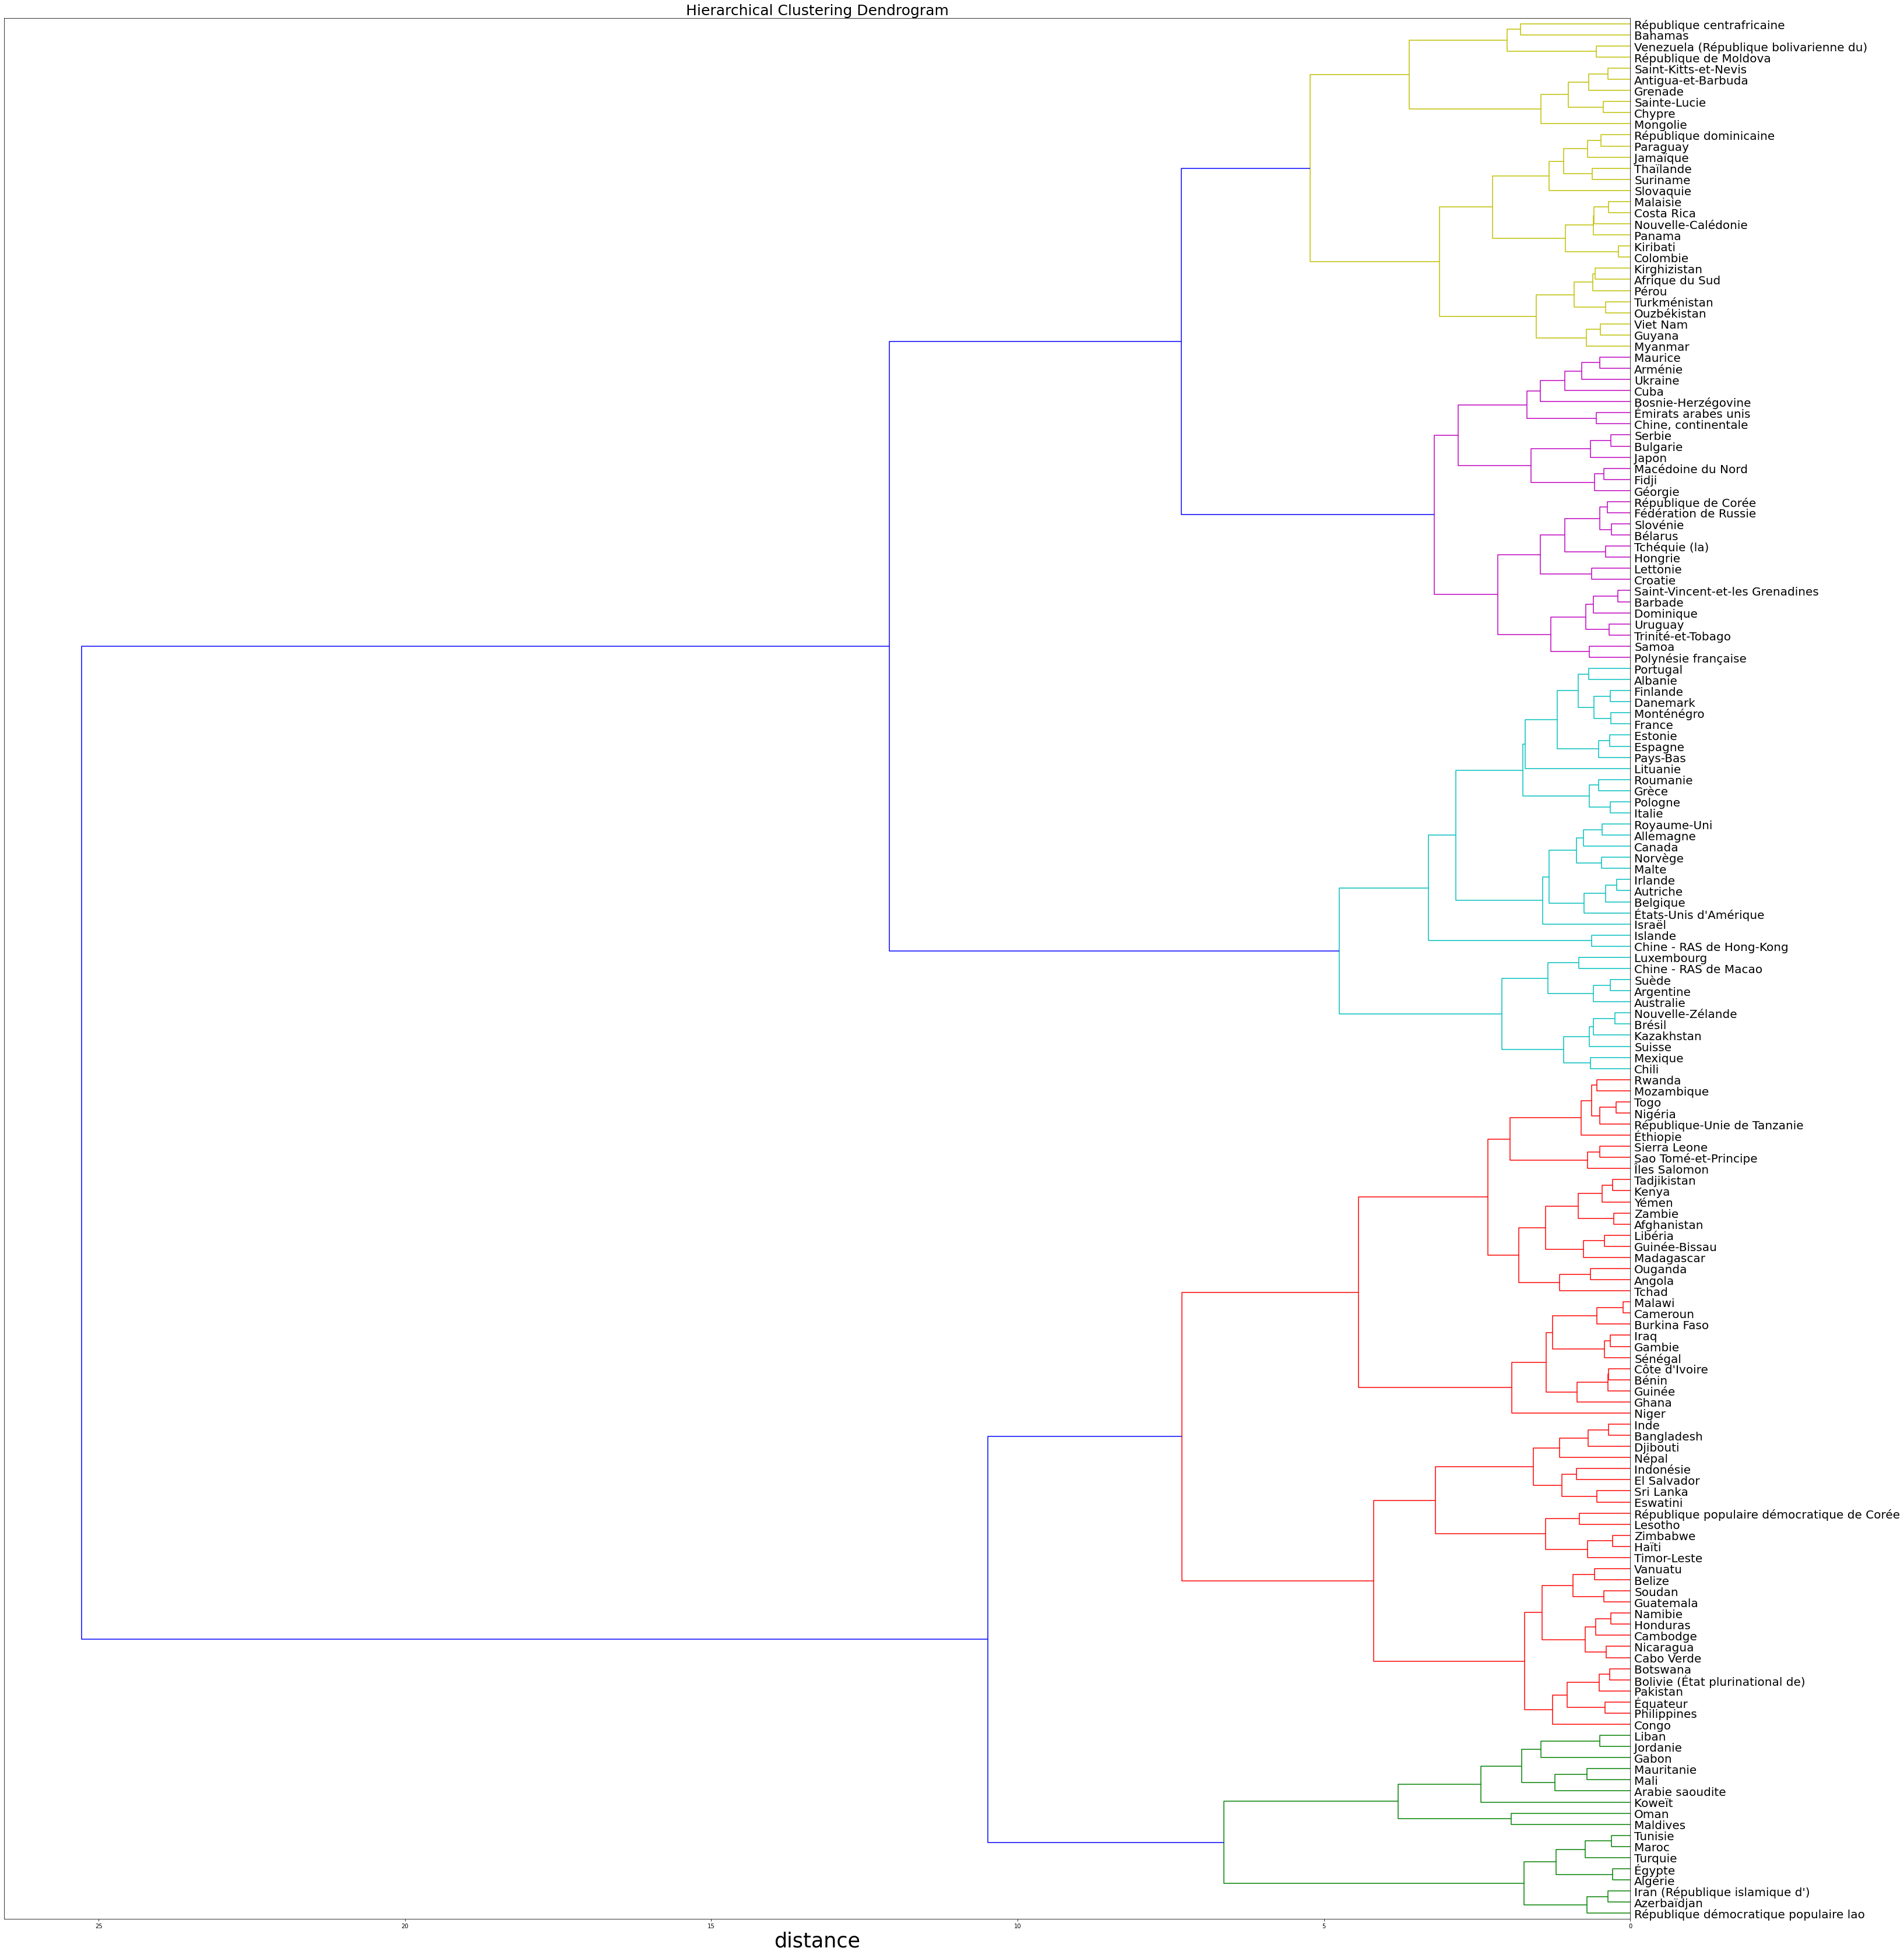

In [13]:
# préparation des données pour le clustering
X = data.values
names = data.index

# Centrage et Réduction
#X_scaled = preprocessing.StandardScaler().fit_transform(X)

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')


# Affichage du dendrogramme
plot_dendrogram(Z, names)


plt.savefig("P5_01_dendogramme.jpg",bbox="tight")

#Partage en 5 clusters du dindogramme

In [14]:
# Coupage du dendrogramme en 5 clusters
clusters = fcluster(Z, 5, criterion='maxclust')

# Création d'un dataframe contenant le pays ainsi que le cluster auquel il a ete affécté
clustzone = pd.DataFrame({"cluster": clusters, "Zone": names})
clustzone

,cluster,Zone
0,2,Afghanistan
1,5,Afrique du Sud
2,3,Albanie
3,1,Algérie
4,3,Allemagne
...,...,...
166,4,Émirats arabes unis
167,2,Équateur
168,3,États-Unis d'Amérique
169,2,Éthiopie


In [15]:
#Liste des pays contenus dans chaques clusters
for g in range(1,6):
    print("Cluster ",g,":")
    print(". ".join(clustzone[clustzone["cluster"] == g]["Zone"]))
    print(24*"-----")
    print(24*" ")
print("Nombre de pays dans le " ,clustzone.groupby("cluster").size())

Cluster  1 :
Algérie. Arabie saoudite. Azerbaïdjan. Gabon. Iran (République islamique d'). Jordanie. Koweït. Liban. Maldives. Mali. Maroc. Mauritanie. Oman. République démocratique populaire lao. Tunisie. Turquie. Égypte
------------------------------------------------------------------------------------------------------------------------
                        
Cluster  2 :
Afghanistan. Angola. Bangladesh. Belize. Bolivie (État plurinational de). Botswana. Burkina Faso. Bénin. Cabo Verde. Cambodge. Cameroun. Congo. Côte d'Ivoire. Djibouti. El Salvador. Eswatini. Gambie. Ghana. Guatemala. Guinée. Guinée-Bissau. Haïti. Honduras. Inde. Indonésie. Iraq. Kenya. Lesotho. Libéria. Madagascar. Malawi. Mozambique. Namibie. Nicaragua. Niger. Nigéria. Népal. Ouganda. Pakistan. Philippines. Rwanda. République populaire démocratique de Corée. République-Unie de Tanzanie. Sao Tomé-et-Principe. Sierra Leone. Soudan. Sri Lanka. Sénégal. Tadjikistan. Tchad. Timor-Leste. Togo. Vanuatu. Yémen. Zambie.

#Nombre de pays dans le cluster 
##Les clusters paraissent globalement etre classifiés de cette manière
#1 17 : Contient principalement des pays situés autour de la méditerranée
#2 59 : Contient principalement des pays africains 
#3 37 : Contient principalement des pays européens
#4 28 : Contient principalement des pays de l’est
#5 30  : Contient un mélange

#création de la fonction 'clust5' afin de rajouter une colonne 'region' au dataframe pour caracteriser  son cluster.
la region au cluster dans le dataframe

#Integration de la clusterisation au dataframe data contenant les données alimentaires

In [16]:
data = pd.merge(data_pib, clustzone, on=["Zone"],how="inner" ).copy()

#Ajout d’une colonne région au tableau de données

In [17]:
clust5(data) #utilisation de la fonction clust5

Partage en 5 régions


,Zone,evod,Disp_alim_tot_(Kcal/pers/j),Disp_prot_tot_(g/pers/j),ratio_p_ani,pib_pa,cluster,groupe
0,Afghanistan,19.29,2000.0,54.09,0.20,618.989990,2,Africains
1,Afrique du Sud,9.39,2994.0,83.41,0.41,6151.086799,5,Autres
2,Albanie,-1.08,3399.0,119.55,0.55,4450.008107,3,Européens
3,Algérie,12.96,3349.0,92.92,0.28,4055.246580,1,Méditerranéens
4,Allemagne,2.66,3556.0,104.21,0.61,44976.426157,3,Européens
...,...,...,...,...,...,...,...,...
166,Émirats arabes unis,5.35,3366.0,107.34,0.41,40698.844531,4,Pays de l'est
167,Équateur,10.41,2586.0,65.78,0.46,6273.488892,2,Africains
168,États-Unis d'Amérique,4.16,3766.0,113.73,0.65,60054.941286,3,Européens
169,Éthiopie,17.79,2303.0,65.65,0.09,720.339679,2,Africains


In [18]:
data.iloc[:,1:5]#visualisation des données nécessaires à l'ACP

,evod,Disp_alim_tot_(Kcal/pers/j),Disp_prot_tot_(g/pers/j),ratio_p_ani
0,19.29,2000.0,54.09,0.20
1,9.39,2994.0,83.41,0.41
2,-1.08,3399.0,119.55,0.55
3,12.96,3349.0,92.92,0.28
4,2.66,3556.0,104.21,0.61
...,...,...,...,...
166,5.35,3366.0,107.34,0.41
167,10.41,2586.0,65.78,0.46
168,4.16,3766.0,113.73,0.65
169,17.79,2303.0,65.65,0.09


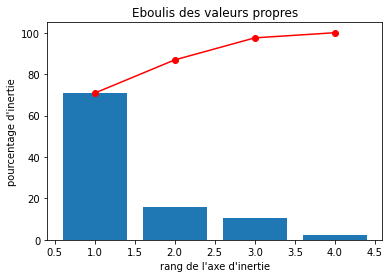

In [19]:
# choix du nombre de composantes à calculer
n_comp = 4

# selection des colonnes à prendre en compte dans l'ACP
data_pca = data.iloc[:,1:5]

# préparation des données pour l'ACP
data_pca = data_pca.fillna(data_pca.mean()) # remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values
names = data.Zone # ou data.index pour avoir les intitulés
features = data_pca.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
#X_scaled = preprocessing.StandardScaler().fit_transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

#plt.savefig("comp4.jpg",bbox="tight")

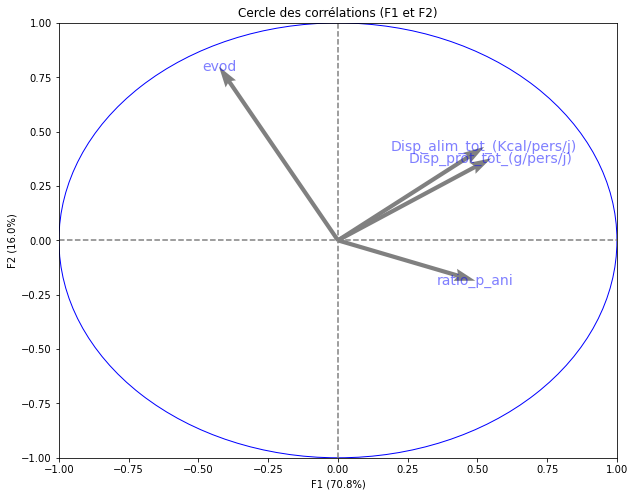

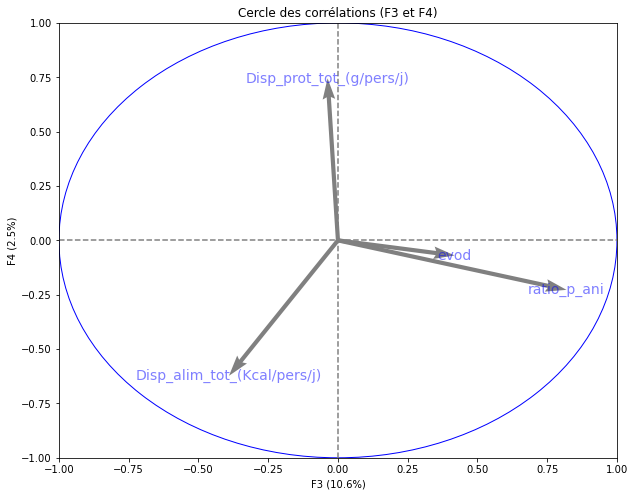

In [20]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

#plt.savefig("cercles.jpg",bbox="tight")

<Figure size 720x360 with 0 Axes>

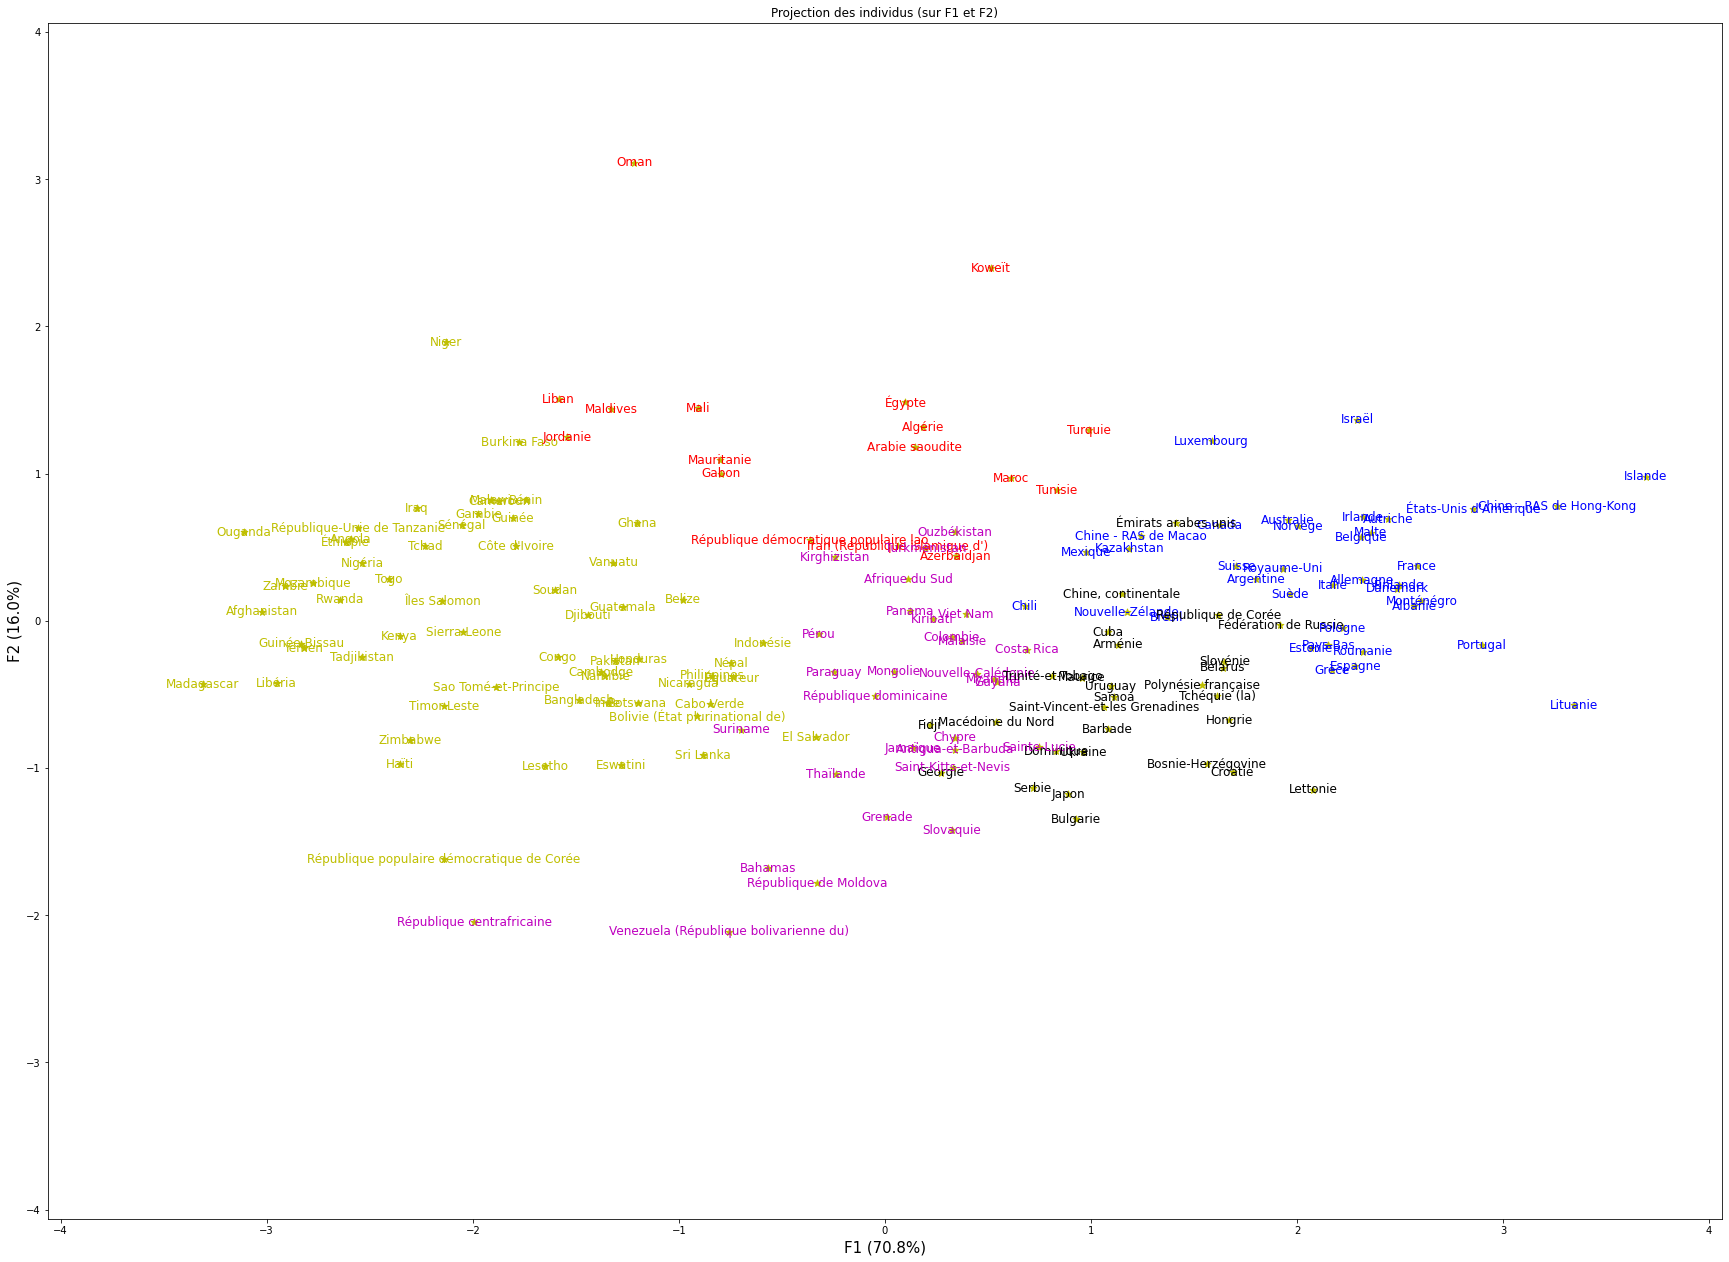

In [21]:
# Projection des individus
plt.figure(figsize=(10,5))
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], labels = data.Zone, clusters = data.groupe)
#plt.savefig("individus.jpg",bbox="tight")

#pays et leurs clusters
#création du dataframe F_data contenant toutes les donnés

In [22]:
df = pd.DataFrame(data=X_projected, columns=["F1", "F2", "F3", "F4"])
F_data = pd.concat([df, data.iloc[:,0].to_frame()], axis=1).copy()
F_data = pd.merge(F_data, data, on=["Zone"],how="inner" ).copy()
F_data = F_data[[ 'Zone','F1', 'F2', 'F3', 'F4', 'Disp_alim_tot_(Kcal/pers/j)','Disp_prot_tot_(g/pers/j)', 'ratio_p_ani', 'evod', 'pib_pa', 'cluster','groupe']]
F_data.sort_values(by='F1')# l axe F1(x) represente la disponibilité alimentaire
#data.sort_values(by='y')# l axe F2(y) represente la croissance demographique

,Zone,F1,F2,F3,F4,Disp_alim_tot_(Kcal/pers/j),Disp_prot_tot_(g/pers/j),ratio_p_ani,evod,pib_pa,cluster,groupe
88,Madagascar,-3.310047,-0.431634,0.273581,0.126102,1903.0,42.94,0.21,17.52,516.540042,2,Africains
111,Ouganda,-3.112529,0.604921,0.378765,0.086259,2145.0,52.35,0.21,23.64,646.217765,2,Africains
0,Afghanistan,-3.023706,0.062655,0.213970,0.402613,2000.0,54.09,0.20,19.29,618.989990,2,Africains
84,Libéria,-2.951381,-0.422437,0.234230,-0.347169,2131.0,39.89,0.25,16.52,583.830053,2,Africains
163,Zambie,-2.909851,0.237449,0.229786,0.563161,2013.0,59.09,0.20,19.96,1513.276223,2,Africains
...,...,...,...,...,...,...,...,...,...,...,...,...
168,États-Unis d'Amérique,2.854451,0.762545,0.075970,-0.326077,3766.0,113.73,0.65,4.16,60054.941286,3,Européens
120,Portugal,2.897812,-0.166797,-0.103793,0.153814,3491.0,114.49,0.64,-2.57,18881.948154,3,Européens
31,Chine - RAS de Hong-Kong,3.262636,0.781356,0.816990,1.007952,3358.0,137.93,0.73,4.61,46390.334337,3,Européens
85,Lituanie,3.343696,-0.574849,-0.458564,0.724221,3419.0,125.18,0.62,-8.02,16449.679586,3,Européens


##fichier CSV contenant la liste des pays ainsi que (pour chacun d'entre eux) leur groupe déterminé après avoir découpé le dendrogramme

In [23]:
pays_groupes = data[['Zone','groupe']].copy()
pays_groupes.rename(columns={"Zone":"pays"},inplace=True)
pays_groupes.to_csv("pays_groupes.csv", index = True)
pays_groupes

,pays,groupe
0,Afghanistan,Africains
1,Afrique du Sud,Autres
2,Albanie,Européens
3,Algérie,Méditerranéens
4,Allemagne,Européens
...,...,...
166,Émirats arabes unis,Pays de l'est
167,Équateur,Africains
168,États-Unis d'Amérique,Européens
169,Éthiopie,Africains


#moyennes des groupes(clusters)

##création du dataframe c_data contenant toutes moyennes des groupes et leurs centroids
#Création d'un ficher CSV contenant les centroïdes des groupes et leurs coordonnées dans chacune des dimensions.

In [24]:
c_data = F_data.groupby("groupe").mean()
c_data = c_data.rename(index={1: "Méditerranéens", 2: "Africains", 3: "Européens", 4: "Pays de l'est", 5: "Autres"})
c_data = c_data.reset_index()
centroids = c_data[['groupe', 'F1', 'F2', 'F3', 'F4']].copy()
centroids.to_csv("centroids.csv", index = True)
c_data

,groupe,F1,F2,F3,F4,Disp_alim_tot_(Kcal/pers/j),Disp_prot_tot_(g/pers/j),ratio_p_ani,evod,pib_pa,cluster
0,Africains,-1.847480,-0.015248,-0.152639,0.036257,2433.338983,61.296949,0.260169,13.936102,2017.039876,2
1,Autres,0.037711,-0.583380,0.465490,-0.068622,2691.033333,75.826333,0.510000,6.256667,9319.631297,5
2,Européens,2.146202,0.328768,0.100116,0.046941,3402.972973,108.170270,0.596757,3.692973,39402.326659,3
3,Méditerranéens,-0.279797,1.287071,-0.075563,-0.038666,3068.176471,87.417059,0.357647,17.104706,7861.884546,1
4,Pays de l'est,1.186324,-0.558698,-0.263526,-0.041429,3090.785714,89.707143,0.503214,0.243929,13154.489683,4


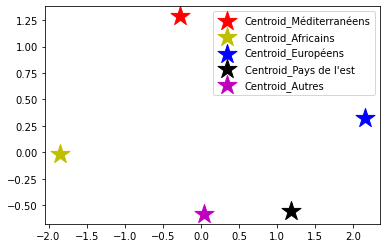

In [25]:
# Affichage des centroids par projection sur le premier plan factoriel

plt.scatter(F_data['F1'].loc[(F_data['cluster'] == 1 )].mean(), F_data['F2'].loc[(F_data['cluster'] == 1 )].mean(), color='r',marker = '*',s=400, label = 'Centroid_Méditerranéens' )
plt.scatter(F_data['F1'].loc[(F_data['cluster'] == 2 )].mean(), F_data['F2'].loc[(F_data['cluster'] == 2 )].mean(), color='y',marker = '*',s=400, label = 'Centroid_Africains' )
plt.scatter(F_data['F1'].loc[(F_data['cluster'] == 3 )].mean(), F_data['F2'].loc[(F_data['cluster'] == 3 )].mean(), color='b',marker = '*',s=400, label = 'Centroid_Européens' )
plt.scatter(F_data['F1'].loc[(F_data['cluster'] == 4 )].mean(), F_data['F2'].loc[(F_data['cluster'] == 4 )].mean(), color='k',marker = '*',s=400, label = "Centroid_Pays de l'est" )
plt.scatter(F_data['F1'].loc[(F_data['cluster'] == 5 )].mean(), F_data['F2'].loc[(F_data['cluster'] == 5 )].mean(), color='m',marker = '*',s=400, label = 'Centroid_Autres' )

#plt.scatter(c_data['F1'], c_data['F2'], color='k',marker = '*',s=300, label = 'centroids' )

plt.legend()
plt.draw()

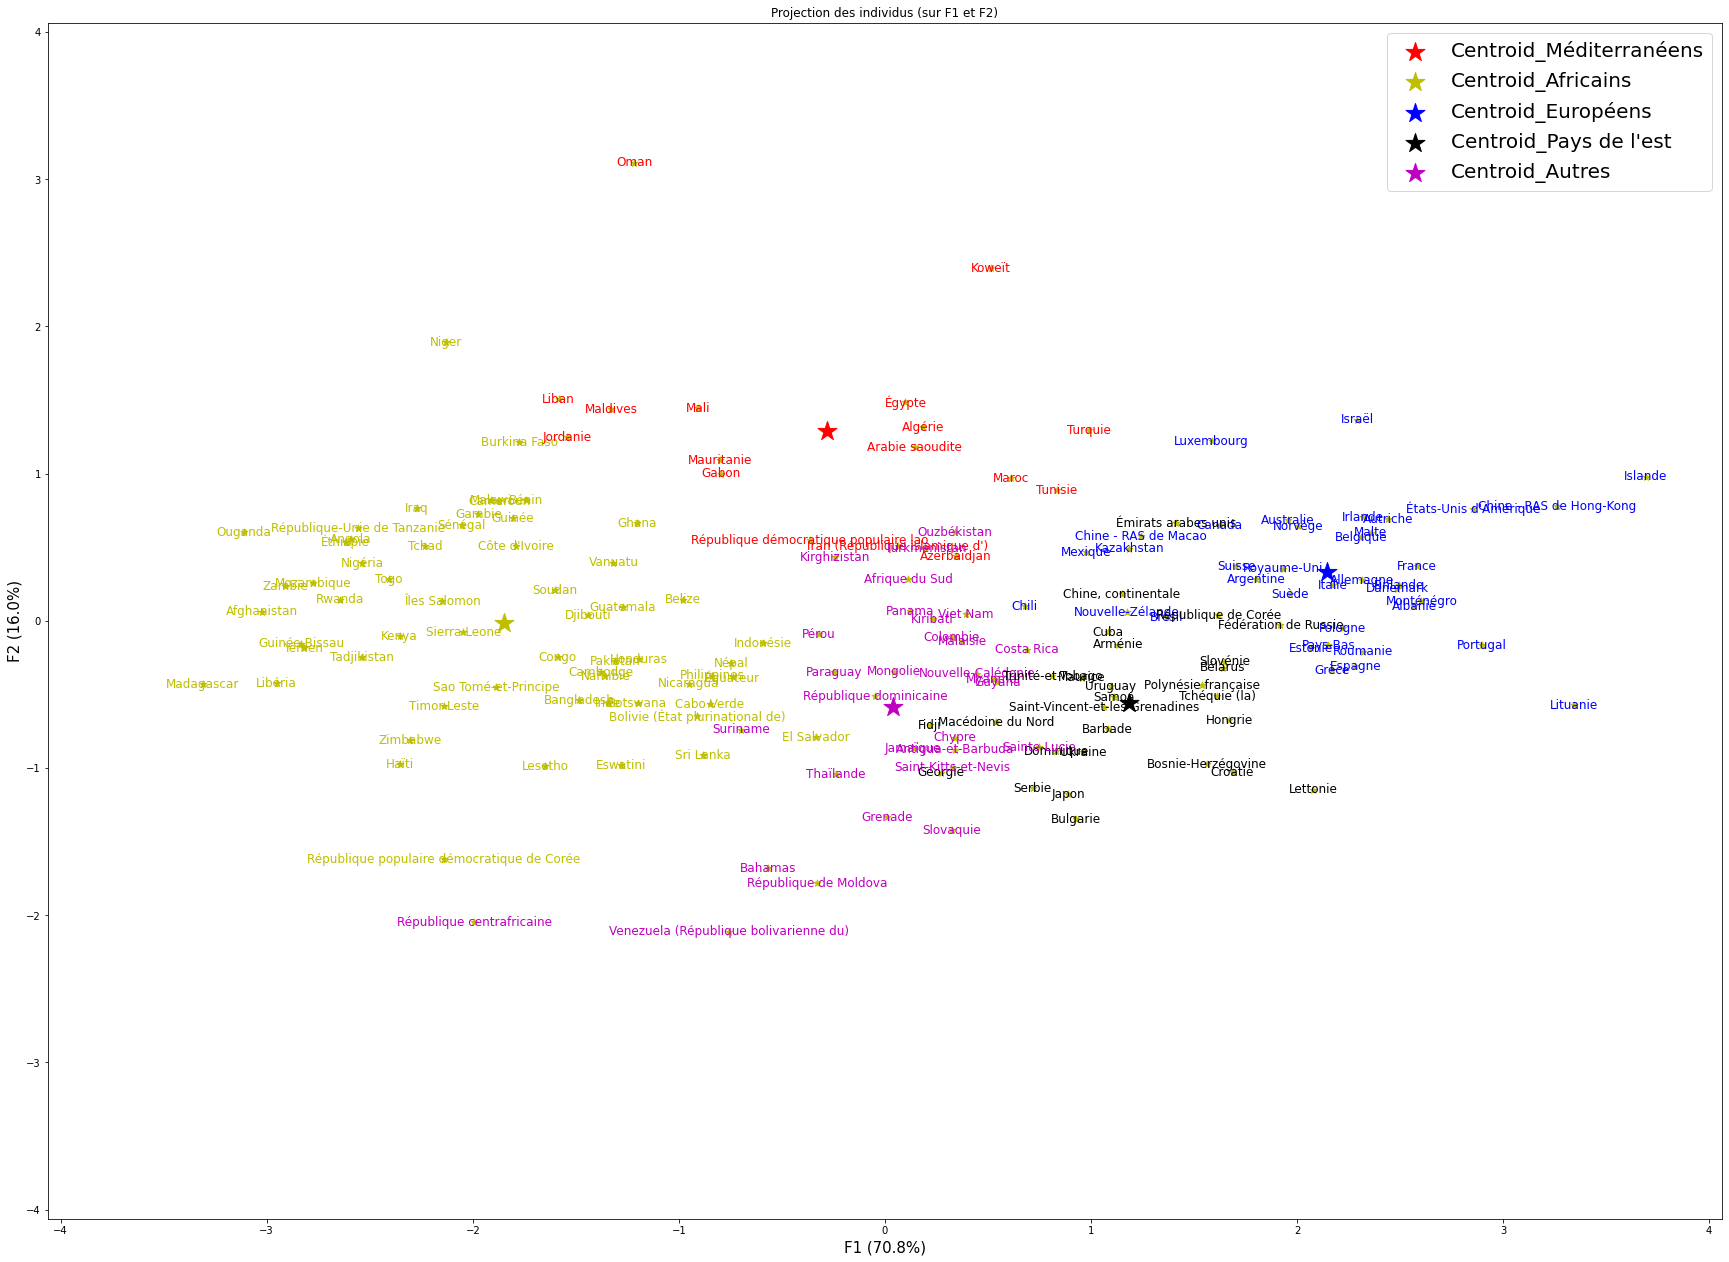

In [26]:
# Affichage des clusters par projection des individus sur le premier plan factoriel avec leurs centroids

display_factorial_planes(X_projected, n_comp, pca, [(0,1)], labels = data.Zone, clusters = data.groupe)

# Affichage des centroids par projection des individus sur le premier plan factoriel

plt.scatter(F_data['F1'].loc[(F_data['cluster'] == 1 )].mean(), F_data['F2'].loc[(F_data['cluster'] == 1 )].mean(), color='r',marker = '*',s=400, label = 'Centroid_Méditerranéens' )
plt.scatter(F_data['F1'].loc[(F_data['cluster'] == 2 )].mean(), F_data['F2'].loc[(F_data['cluster'] == 2 )].mean(), color='y',marker = '*',s=400, label = 'Centroid_Africains' )
plt.scatter(F_data['F1'].loc[(F_data['cluster'] == 3 )].mean(), F_data['F2'].loc[(F_data['cluster'] == 3 )].mean(), color='b',marker = '*',s=400, label = 'Centroid_Européens' )
plt.scatter(F_data['F1'].loc[(F_data['cluster'] == 4 )].mean(), F_data['F2'].loc[(F_data['cluster'] == 4 )].mean(), color='k',marker = '*',s=400, label = "Centroid_Pays de l'est" )
plt.scatter(F_data['F1'].loc[(F_data['cluster'] == 5 )].mean(), F_data['F2'].loc[(F_data['cluster'] == 5 )].mean(), color='m',marker = '*',s=400, label = 'Centroid_Autres' )

#plt.scatter(c_data['F1'], c_data['F2'], color='k',marker = '*',s=300, label = 'centroids' )

plt.legend(fontsize=20)

#plt.savefig("c_individus.jpg",bbox="tight")

plt.draw()

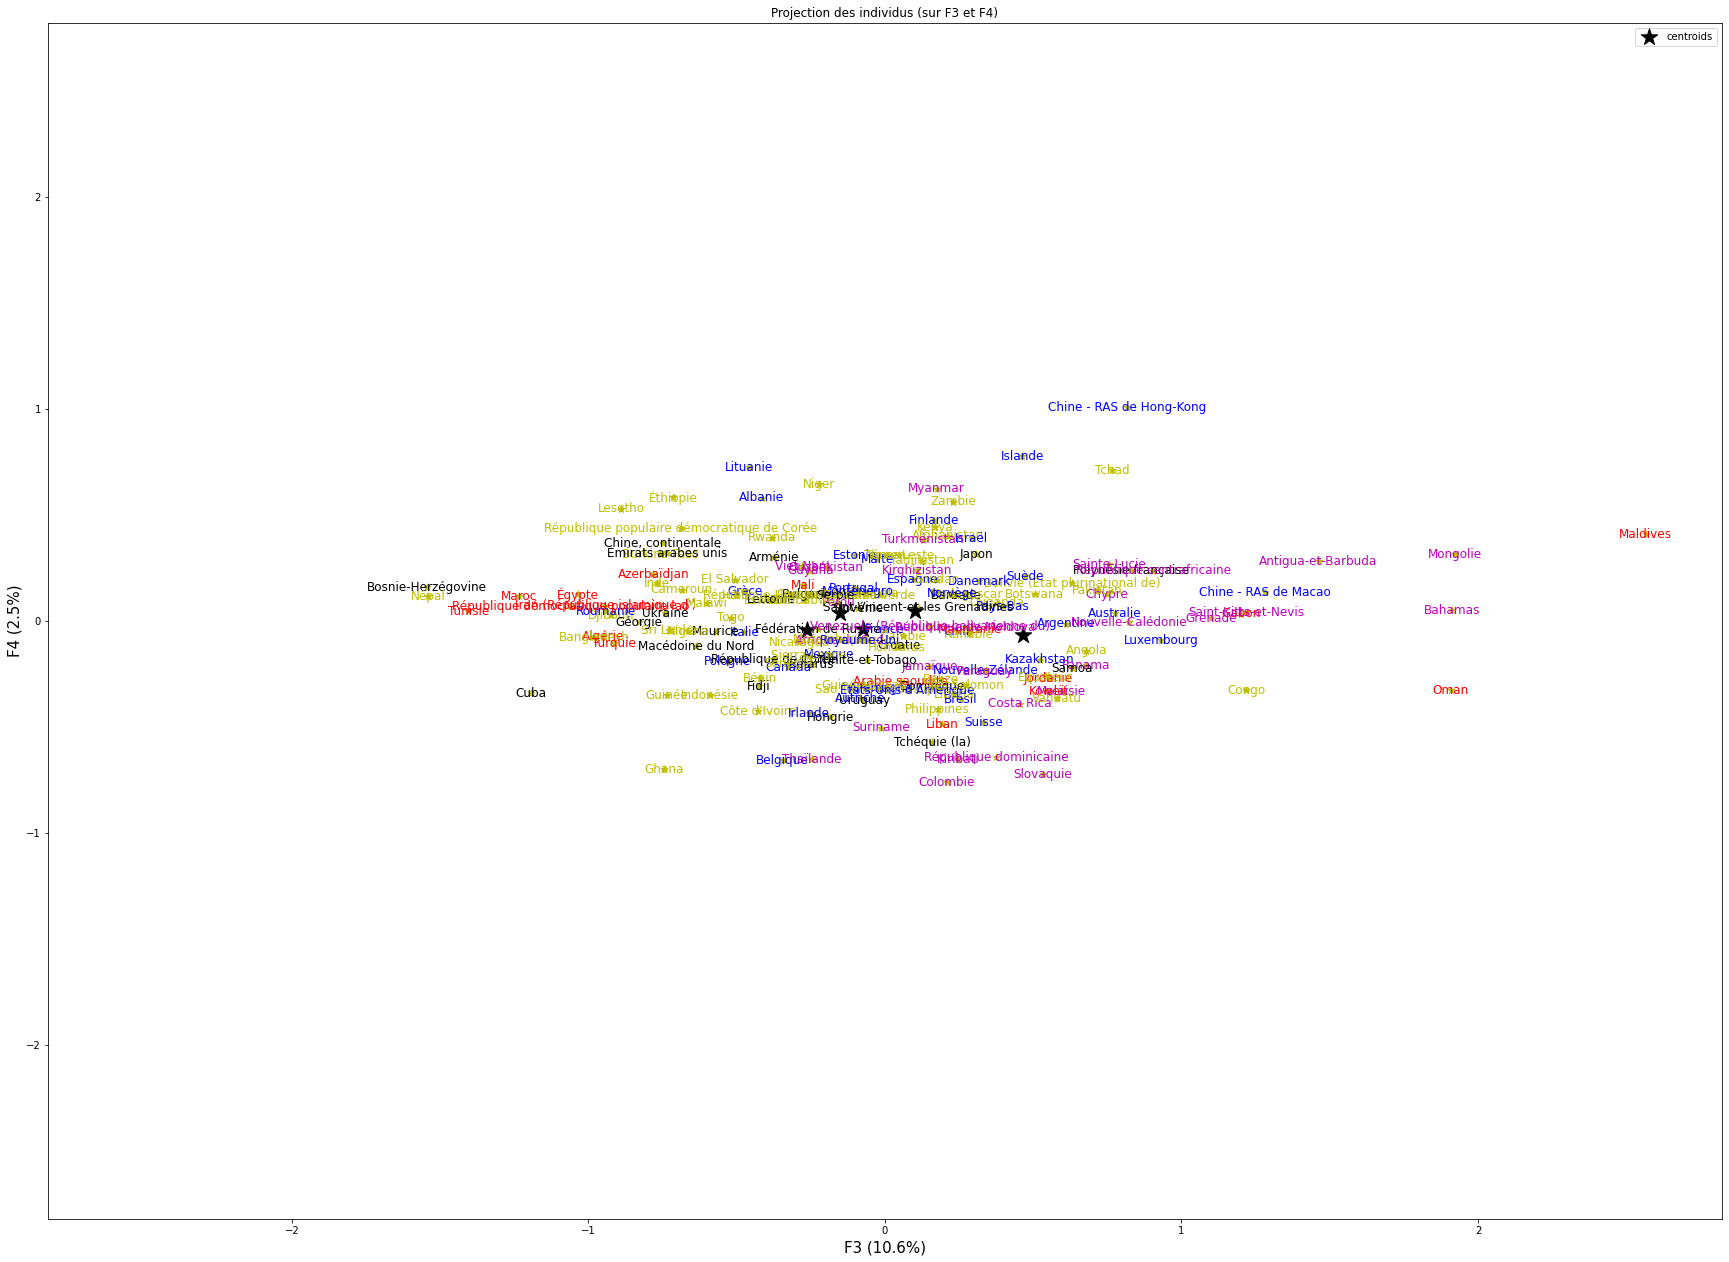

In [27]:
# Affichage des clusters par projection des individus sur le premier plan factoriel de P3 et P4

display_factorial_planes(X_projected, n_comp, pca, [(2,3)], labels = data.Zone, clusters = data.groupe)

# Affichage des centroids par projection des individus sur le premier plan factoriel

#plt.scatter(c_data['F3'].loc[(c_data['cluster'] == 1 )].mean(), c_data['F4'].loc[(c_data['cluster'] == 1 )].mean(), color='r',marker = '*',s=400, label = 'Centroid_Méditerranéens' )
#plt.scatter(c_data['F3'].loc[(c_data['cluster'] == 2 )].mean(), c_data['F4'].loc[(c_data['cluster'] == 2 )].mean(), color='y',marker = '*',s=400, label = 'Centroid_Africains' )
#plt.scatter(c_data['F3'].loc[(c_data['cluster'] == 3 )].mean(), c_data['F4'].loc[(c_data['cluster'] == 3 )].mean(), color='b',marker = '*',s=400, label = 'Centroid_Européens' )
#plt.scatter(c_data['F3'].loc[(c_data['cluster'] == 4 )].mean(), c_data['F4'].loc[(c_data['cluster'] == 4 )].mean(), color='k',marker = '*',s=400, label = "Centroid_Pays de l'est" )
#plt.scatter(c_data['F3'].loc[(c_data['cluster'] == 5 )].mean(), c_data['F4'].loc[(c_data['cluster'] == 5 )].mean(), color='m',marker = '*',s=400, label = 'Centroid_Autres' )
plt.scatter(c_data['F3'], c_data['F4'], color='k',marker = '*',s=300, label = 'centroids' )

plt.legend()
plt.draw()

In [28]:
c_data

,groupe,F1,F2,F3,F4,Disp_alim_tot_(Kcal/pers/j),Disp_prot_tot_(g/pers/j),ratio_p_ani,evod,pib_pa,cluster
0,Africains,-1.847480,-0.015248,-0.152639,0.036257,2433.338983,61.296949,0.260169,13.936102,2017.039876,2
1,Autres,0.037711,-0.583380,0.465490,-0.068622,2691.033333,75.826333,0.510000,6.256667,9319.631297,5
2,Européens,2.146202,0.328768,0.100116,0.046941,3402.972973,108.170270,0.596757,3.692973,39402.326659,3
3,Méditerranéens,-0.279797,1.287071,-0.075563,-0.038666,3068.176471,87.417059,0.357647,17.104706,7861.884546,1
4,Pays de l'est,1.186324,-0.558698,-0.263526,-0.041429,3090.785714,89.707143,0.503214,0.243929,13154.489683,4


In [29]:
#création de c_data2 qui est un c_data arrondit et retrait des colonnes de projection

In [30]:
c_data2 = c_data[['groupe', 'pib_pa', 'ratio_p_ani','evod', 'Disp_alim_tot_(Kcal/pers/j)','Disp_prot_tot_(g/pers/j)']].copy()
c_data2 = round(c_data2,2)
c_data2.sort_values(by='pib_pa')

,groupe,pib_pa,ratio_p_ani,evod,Disp_alim_tot_(Kcal/pers/j),Disp_prot_tot_(g/pers/j)
0,Africains,2017.04,0.26,13.94,2433.34,61.30
3,Méditerranéens,7861.88,0.36,17.10,3068.18,87.42
1,Autres,9319.63,0.51,6.26,2691.03,75.83
4,Pays de l'est,13154.49,0.50,0.24,3090.79,89.71
2,Européens,39402.33,0.60,3.69,3402.97,108.17


In [31]:
#création de F_data2 qui est un F_data arrondit et retrait des colonnes de projection F3 et F4

In [32]:
F_data2 = F_data[['Zone','groupe', 'F1', 'pib_pa', 'ratio_p_ani','evod', 'F2', 'Disp_alim_tot_(Kcal/pers/j)','Disp_prot_tot_(g/pers/j)']].copy()
F_data2.sort_values(by='F1').head(10)

,Zone,groupe,F1,pib_pa,ratio_p_ani,evod,F2,Disp_alim_tot_(Kcal/pers/j),Disp_prot_tot_(g/pers/j)
88,Madagascar,Africains,-3.310047,516.540042,0.21,17.52,-0.431634,1903.0,42.94
111,Ouganda,Africains,-3.112529,646.217765,0.21,23.64,0.604921,2145.0,52.35
0,Afghanistan,Africains,-3.023706,618.989990,0.20,19.29,0.062655,2000.0,54.09
84,Libéria,Africains,-2.951381,583.830053,0.25,16.52,-0.422437,2131.0,39.89
163,Zambie,Africains,-2.909851,1513.276223,0.20,19.96,0.237449,2013.0,59.09
59,Guinée-Bissau,Africains,-2.832559,723.633954,0.21,16.78,-0.154077,2253.0,44.15
162,Yémen,Africains,-2.817866,989.605354,0.20,16.45,-0.186944,2063.0,53.23
100,Mozambique,Africains,-2.775817,426.438077,0.18,18.64,0.253819,2305.0,51.21
124,Rwanda,Africains,-2.642222,748.350053,0.15,16.61,0.143782,2215.0,59.24
169,Éthiopie,Africains,-2.616597,720.339679,0.09,17.79,0.538309,2303.0,65.65


##un test d'adéquation : parmi les 4 variables, ou parmi d'autres variables que vous trouverez pertinentes, trouvez une variable dont la loi est normale ;

#tableau de test shapiro sur les variables et les groupes avec la fonction shap_test crée au préalable

In [33]:
data_temp = data[['Zone', 'Disp_alim_tot_(Kcal/pers/j)', 'Disp_prot_tot_(g/pers/j)','ratio_p_ani', 'evod', 'pib_pa', 'groupe']].copy()
shapi = pd.pivot_table(data_temp.iloc[:,1:7], index=['groupe'] , aggfunc = shap_test )
shapi.rename(columns={"Disp_alim_tot_(Kcal/pers/j)":"Disp_alim_tot"},inplace=True)
shapi.rename(columns={"Disp_prot_tot_(g/pers/j)":"Disp_prot_tot"},inplace=True)
shapi

,Disp_alim_tot,Disp_prot_tot,evod,pib_pa,ratio_p_ani
groupe,,,,,
Africains,0.762,0.643,0.114,0.000,0.021
Autres,0.008,0.329,0.812,0.000,0.088
Européens,0.709,0.030,0.979,0.056,0.859
Méditerranéens,0.505,0.343,0.172,0.003,0.036
Pays de l'est,0.550,0.849,0.039,0.001,0.189


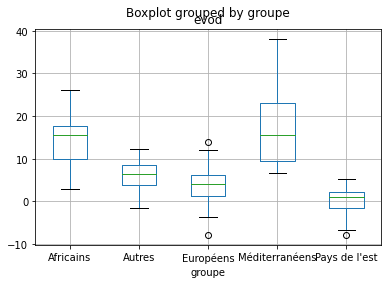

In [34]:
data.boxplot(column="evod",by="groupe")

In [35]:
shap(data[data['groupe'] == 'Européens']['evod'])

Statistics=0.990, p=0.979
L'echantillon semble Gaussien (seuil tolerance 5%, Hypothèse nulle H0 non rejetée, test shapiro)


In [36]:
shap(data[data['groupe'] == 'Autres']['evod'])

Statistics=0.980, p=0.812
L'echantillon semble Gaussien (seuil tolerance 5%, Hypothèse nulle H0 non rejetée, test shapiro)


##un test de comparaison de deux populations (dans le cas gaussien) : choisissez 2 clusters parmi ceux que vous aurez déterminé. Sur ces 2 clusters, testez la variable gaussienne grâce à un test de comparaison.

In [37]:
evod_2 = data[data['groupe'] == 'Africains']['evod']
evod_3 = data[data['groupe'] == 'Européens']['evod']
evod_4 = data[data["groupe"] == "Pays de l'est"]['evod']
evod_5 = data[data['groupe'] == 'Autres']['evod']
evod_1 = data[data['groupe'] == 'Méditerranéens']['evod']

In [38]:
# comparaison des echantillons
stat, p = ttest_ind(evod_3, evod_5)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Distributions identiques (nous ne rejetons pas H0)')
else:
    print('Distributions differentes (nous rejetons H0)')

Statistics=-2.565, p=0.013
Distributions differentes (nous rejetons H0)


#Un découpage plus précis qu'en 5 groupes peut si besoin être effectué pour cibler un nombre raisonnable de pays. 

In [39]:
# découpage du dendrogramme en 18 clusters afin d'optimiser le groupe "européens"
clusters = fcluster(Z, 18, criterion='maxclust')

In [40]:
# Création d'un dataframe contenant le pays ainsi que le cluster auquel il a ete affécté
clustzone = pd.DataFrame({"cluster": clusters, "Zone": names})
clustzone.head(5)

,cluster,Zone
0,8,Afghanistan
1,15,Afrique du Sud
2,12,Albanie
3,1,Algérie
4,11,Allemagne


In [41]:
#Liste des pays contenus dans chaques clusters
for g in range(1,19):
    print("Cluster ",g,":")
    print(". ".join(clustzone[clustzone["cluster"] == g]["Zone"]))
    print(24*"-----")
    print(24*" ")
print("Nombre de pays dans le " ,clustzone.groupby("cluster").size())

Cluster  1 :
Algérie. Azerbaïdjan. Iran (République islamique d'). Maroc. République démocratique populaire lao. Tunisie. Turquie. Égypte
------------------------------------------------------------------------------------------------------------------------
                        
Cluster  2 :
Maldives. Oman
------------------------------------------------------------------------------------------------------------------------
                        
Cluster  3 :
Arabie saoudite. Gabon. Jordanie. Koweït. Liban. Mali. Mauritanie
------------------------------------------------------------------------------------------------------------------------
                        
Cluster  4 :
Belize. Bolivie (État plurinational de). Botswana. Cabo Verde. Cambodge. Congo. Guatemala. Honduras. Namibie. Nicaragua. Pakistan. Philippines. Soudan. Vanuatu. Équateur
------------------------------------------------------------------------------------------------------------------------
             

In [42]:
data_E = data[['Zone', 'Disp_alim_tot_(Kcal/pers/j)', 'Disp_prot_tot_(g/pers/j)','ratio_p_ani', 'evod', 'pib_pa']].copy()

In [43]:
data_E = pd.merge(data_E, clustzone, on=["Zone"],how="inner" ).copy()

In [44]:
df = pd.DataFrame(data=X_projected, columns=["F1", "F2", "F3", "F4"])
temp_data = pd.concat([df, data_E.iloc[:,0].to_frame()], axis=1).copy()
data_E = pd.merge(data_E,temp_data, on=["Zone"],how="inner" ).copy()
del temp_data
data_E

,Zone,Disp_alim_tot_(Kcal/pers/j),Disp_prot_tot_(g/pers/j),ratio_p_ani,evod,pib_pa,cluster,F1,F2,F3,F4
0,Afghanistan,2000.0,54.09,0.20,19.29,618.989990,8,-3.023706,0.062655,0.213970,0.402613
1,Afrique du Sud,2994.0,83.41,0.41,9.39,6151.086799,15,0.112307,0.284740,-0.152667,-0.090093
2,Albanie,3399.0,119.55,0.55,-1.08,4450.008107,12,2.569522,0.098999,-0.415093,0.581538
3,Algérie,3349.0,92.92,0.28,12.96,4055.246580,1,0.182712,1.318035,-0.949402,-0.073052
4,Allemagne,3556.0,104.21,0.61,2.66,44976.426157,11,2.312979,0.277699,-0.012095,-0.318623
...,...,...,...,...,...,...,...,...,...,...,...
166,Émirats arabes unis,3366.0,107.34,0.41,5.35,40698.844531,14,1.413992,0.666469,-0.734922,0.318389
167,Équateur,2586.0,65.78,0.46,10.41,6273.488892,4,-0.739293,-0.383406,0.542252,-0.261036
168,États-Unis d'Amérique,3766.0,113.73,0.65,4.16,60054.941286,11,2.854451,0.762545,0.075970,-0.326077
169,Éthiopie,2303.0,65.65,0.09,17.79,720.339679,8,-2.616597,0.538309,-0.713146,0.583569


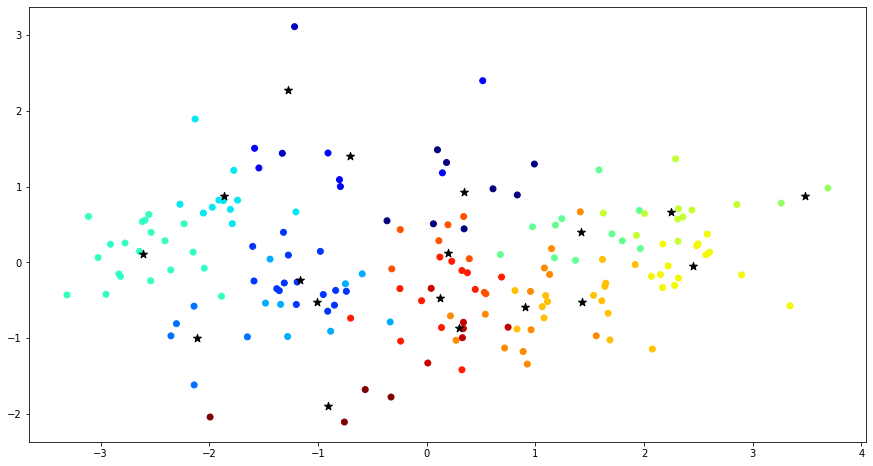

In [45]:
# Projection des individus (18 groupes avec 18 centroids)
plt.figure(figsize=(15,8))

plt.scatter(data_E['F1'],data_E['F2'],c=data_E['cluster'],cmap='jet')
for g in range(1,19):
    plt.scatter((data_E[data_E["cluster"] == g]["F1"]).mean(), (data_E[data_E["cluster"] == g]["F2"]).mean(), color='k',marker = '*',s=70,)
plt.draw()

In [46]:
#Création du dataframe F_dataE contenant les 4 clusters qui composent le groupe "Européens"

In [47]:
F_dataE = pd.concat([data_E[(data_E["cluster"]== 9 )], data_E[(data_E["cluster"]== 10 )], data_E[(data_E["cluster"]== 11 )], data_E[(data_E["cluster"]== 12 )]], axis=0).copy()
F_dataE.head(10)

,Zone,Disp_alim_tot_(Kcal/pers/j),Disp_prot_tot_(g/pers/j),ratio_p_ani,evod,pib_pa,cluster,F1,F2,F3,F4
8,Argentine,3238.0,102.70,0.64,6.24,14399.621069,9,1.800245,0.283156,0.611478,-0.013001
10,Australie,3311.0,108.10,0.66,8.71,57613.226228,9,1.956655,0.684796,0.774781,0.035334
21,Brésil,3249.0,90.86,0.58,5.11,9821.439776,9,1.368736,0.025698,0.255011,-0.369059
30,Chili,3011.0,88.61,0.51,7.64,15346.727899,9,0.677821,0.100952,0.241503,-0.048491
32,Chine - RAS de Macao,3002.0,100.46,0.67,11.98,80892.811251,9,1.243276,0.575617,1.282564,0.133838
76,Kazakhstan,3196.0,94.98,0.58,9.36,8756.457140,9,1.185262,0.491173,0.522626,-0.182558
86,Luxembourg,3335.0,106.05,0.64,13.82,106805.768781,9,1.585438,1.220057,0.931405,-0.090532
97,Mexique,3260.0,93.40,0.47,7.60,8967.170167,9,0.974107,0.468472,-0.188796,-0.156016
108,Nouvelle-Zélande,3156.0,90.95,0.57,6.15,42934.984819,9,1.175735,0.058322,0.339730,-0.233250
143,Suisse,3414.0,95.58,0.61,6.46,80101.204101,9,1.705380,0.374497,0.331218,-0.476202


Cluster  9 :
Nombre de pays  11
Argentine, Australie, Brésil, Chili, Chine - RAS de Macao, Kazakhstan, Luxembourg, Mexique, Nouvelle-Zélande, Suisse, Suède
Cluster  10 :
Nombre de pays  2
Chine - RAS de Hong-Kong, Islande
Cluster  11 :
Nombre de pays  10
Allemagne, Autriche, Belgique, Canada, Irlande, Israël, Malte, Norvège, Royaume-Uni, États-Unis d'Amérique
Cluster  12 :
Nombre de pays  14
Albanie, Danemark, Espagne, Estonie, Finlande, France, Grèce, Italie, Lituanie, Monténégro, Pays-Bas, Pologne, Portugal, Roumanie


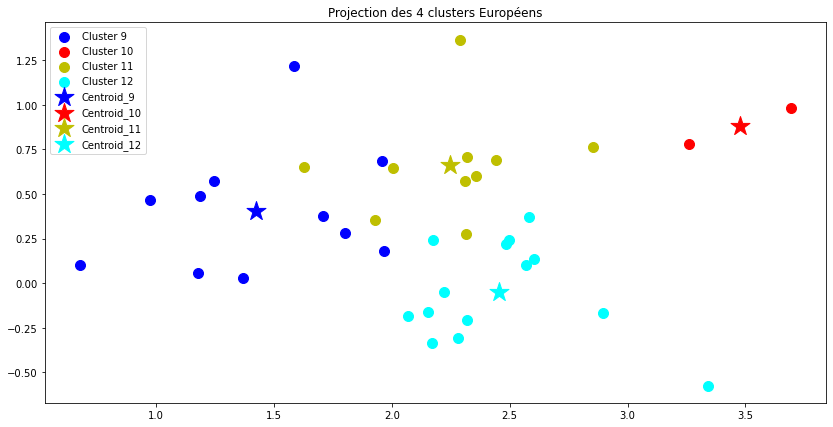

In [48]:
# Projection des 37 individus du groupe "Européens", divisé en 4 clusters et leurs centroids respectifs

for g in range(9,13):
    print("Cluster ",g,":")
    print("Nombre de pays ",(F_dataE[F_dataE["cluster"] == g]["Zone"]).value_counts().sum())
    print(", ".join(F_dataE[F_dataE["cluster"] == g]["Zone"]))
              
          
plt.figure(figsize=(14,7))

plt.scatter(F_dataE[F_dataE["cluster"] == 9]["F1"], F_dataE[F_dataE["cluster"] == 9]["F2"], s = 100, c = 'blue', label = 'Cluster 9')
plt.scatter(F_dataE[F_dataE["cluster"] == 10]["F1"], F_dataE[F_dataE["cluster"] == 10]["F2"], s = 100, c = 'red', label = 'Cluster 10')
plt.scatter(F_dataE[F_dataE["cluster"] == 11]["F1"], F_dataE[F_dataE["cluster"] == 11]["F2"], s = 100, c = 'y', label = 'Cluster 11')
plt.scatter(F_dataE[F_dataE["cluster"] == 12]["F1"], F_dataE[F_dataE["cluster"] == 12]["F2"], s = 100, c = 'cyan', label = 'Cluster 12')


plt.scatter(F_dataE[F_dataE["cluster"] == 9]["F1"].mean(), F_dataE[F_dataE["cluster"] == 9]["F2"].mean(), color='blue',marker = '*',s=400, label = 'Centroid_9' )
plt.scatter(F_dataE[F_dataE["cluster"] == 10]["F1"].mean(), F_dataE[F_dataE["cluster"] == 10]["F2"].mean(), color='red',marker = '*',s=400, label = 'Centroid_10' )
plt.scatter(F_dataE[F_dataE["cluster"] == 11]["F1"].mean(), F_dataE[F_dataE["cluster"] == 11]["F2"].mean(), color='y',marker = '*',s=400, label = 'Centroid_11' )
plt.scatter(F_dataE[F_dataE["cluster"] == 12]["F1"].mean(), F_dataE[F_dataE["cluster"] == 12]["F2"].mean(), color='cyan',marker = '*',s=400, label = 'Centroid_12' )

plt.title('Projection des 4 clusters Européens')
#plt.xlabel('F1 Disponibilite alimentaire')
#plt.ylabel('F2 Croissance demographique')

plt.legend()
plt.draw()
#plt.savefig("Européens.jpg",bbox="tight")

In [49]:
##création du dataframe C_dataE contenant toutes moyennes des données des 4 clusters qui composent le groupe "Européens"

In [50]:
C_dataE = F_dataE.groupby("cluster").mean().copy()
C_dataE =C_dataE [['Disp_alim_tot_(Kcal/pers/j)','Disp_prot_tot_(g/pers/j)', 'ratio_p_ani', 'evod', 'pib_pa']]
C_dataE =round(C_dataE,2)
C_dataE.sort_values(by='pib_pa')# l axe F1(x) represente la disponibilité alimentaire

,Disp_alim_tot_(Kcal/pers/j),Disp_prot_tot_(g/pers/j),ratio_p_ani,evod,pib_pa
cluster,,,,,
12,3411.43,111.17,0.59,-0.67,25821.09
9,3217.36,98.08,0.60,7.96,43607.52
11,3577.40,108.80,0.58,5.04,49725.75
10,3492.50,139.47,0.72,4.00,59725.26


In [ ]:
from scipy.stats import ks_2samp
for column in data.iloc[:,2:7]:
    print ("taille de l'echantillon", np.size(data[column]))
    print("la moyenne de la colonne ",column, data[column].mean())
    print("l'ecart type de la colonne ",column, data[column].std(ddof=1))
    print("la variance de la colonne ",column, data[column].var(ddof=1))
    print("le test shapiro / valable si petit echantillon : ",column, st.shapiro(data[column]))
    print("le test Kolmogorov-Smirnov : ", ks_2samp(data[column],list(np.random.normal(np.mean(data[column]), np.std(data[column]), 1000))))
    print("le test normaltest : ",st.normaltest(data[column]))
    print()

la moyenne de la colonne  Disp_alim_tot_(Kcal/pers/j) 2859.1169590643276
la mediane de la colonne  Disp_alim_tot_(Kcal/pers/j) 2871.0
Statistics=15.189, p=0.001
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, normaltest.)
Statistics=0.981, p=0.018
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, test shapiro)
Statistics=1.000, p=0.000
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, test Kolmogorov-Smirnov.)


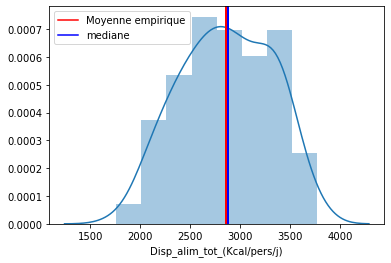

la moyenne de la colonne  Disp_prot_tot_(g/pers/j) 81.23684210526314
la mediane de la colonne  Disp_prot_tot_(g/pers/j) 81.45
Statistics=5.070, p=0.079
L'echantillon semble Gaussien (seuil tolerance 5%, Hypothèse nulle H0 non rejetée, normaltest.)
Statistics=0.979, p=0.010
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, test shapiro)
Statistics=1.000, p=0.000
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, test Kolmogorov-Smirnov.)


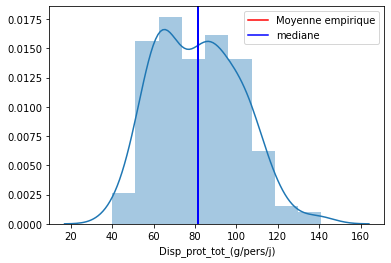

la moyenne de la colonne  ratio_p_ani 0.42631578947368415
la mediane de la colonne  ratio_p_ani 0.44
Statistics=60.029, p=0.000
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, normaltest.)
Statistics=0.955, p=0.000
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, test shapiro)
Statistics=0.546, p=0.000
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, test Kolmogorov-Smirnov.)


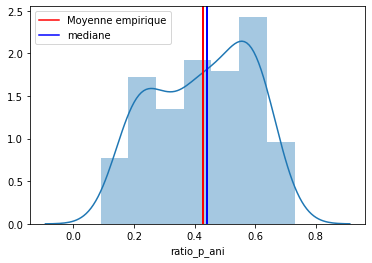

la moyenne de la colonne  evod 8.445497076023393
la mediane de la colonne  evod 7.39
Statistics=11.062, p=0.004
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, normaltest.)
Statistics=0.972, p=0.002
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, test shapiro)
Statistics=0.784, p=0.000
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, test Kolmogorov-Smirnov.)


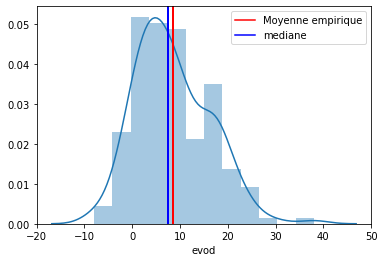

In [56]:
for column in data.iloc[:,2:6]:
    print("la moyenne de la colonne ",column, data[column].mean())
    print("la mediane de la colonne ",column, data[column].median())
    #print("le mode de la colonne ",column, data[column].mode())
    #print("le test normaltest : ",st.normaltest(data[column]))
    # Shapiro-Wilk Test
    norm(data[column])
    shap(data[column])
    kol(data[column])
    #st.kstest(data[column],'norm')
    toto = sns.distplot(data[column]) # Stack these distributions together with different colors
    plt.axvline(data[column].mean(), color='r', linewidth=2)
    plt.axvline(data[column].median(), color='b', linewidth=2)
    plt.legend(handles=[mlines.Line2D([], [], color='red',markersize=15, label="Moyenne empirique"),mlines.Line2D([], [], color='blue',markersize=15, label=u"mediane")])
    plt.show()

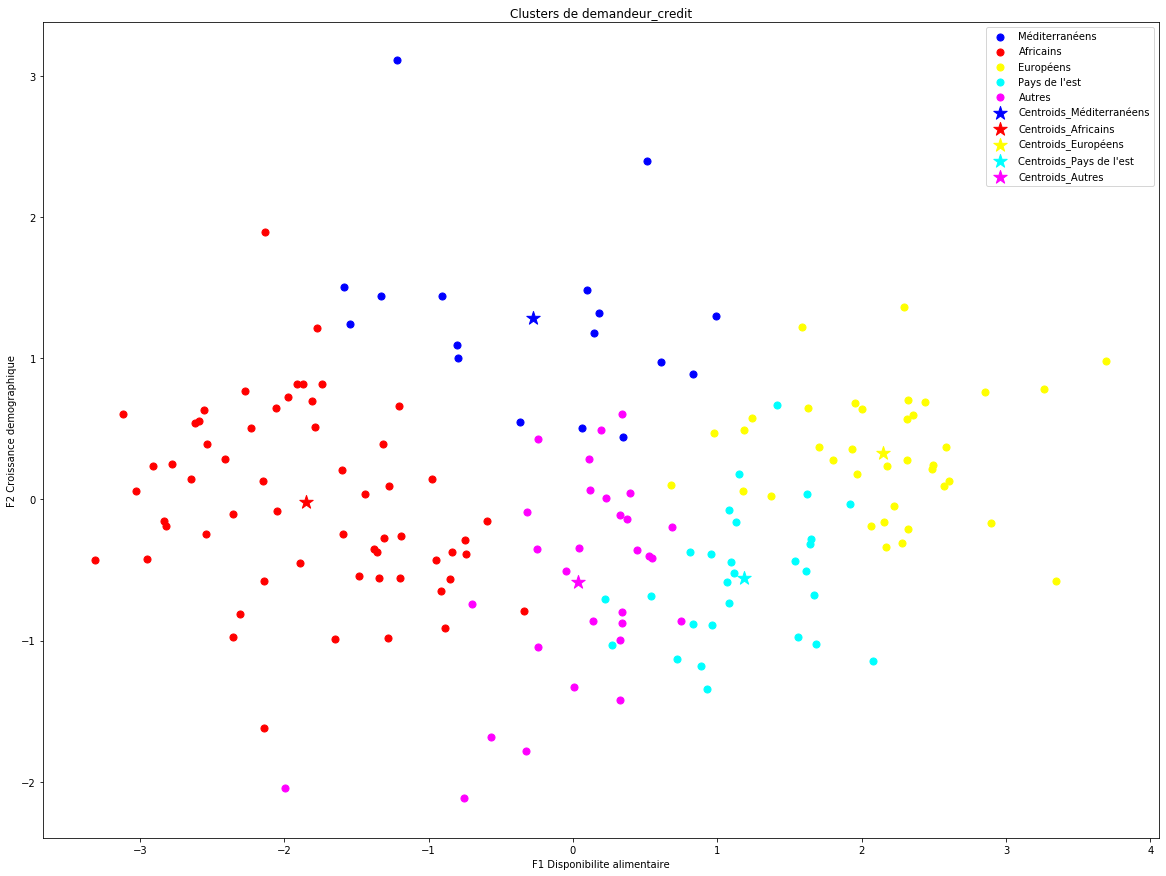

In [44]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,15))
plt.scatter(datax['x'].loc[(datax['cluster'] == 1 )], datax['y'].loc[(datax['cluster'] == 1 )], s = 50, c = 'blue', label = 'Méditerranéens')
plt.scatter(datax['x'].loc[(datax['cluster'] == 2 )], datax['y'].loc[(datax['cluster'] == 2 )], s = 50, c = 'red', label = 'Africains')
plt.scatter(datax['x'].loc[(datax['cluster'] == 3 )], datax['y'].loc[(datax['cluster'] == 3 )], s = 50, c = 'yellow', label = 'Européens')
plt.scatter(datax['x'].loc[(datax['cluster'] == 4 )], datax['y'].loc[(datax['cluster'] == 4 )], s = 50, c = 'cyan', label = "Pays de l'est")
plt.scatter(datax['x'].loc[(datax['cluster'] == 5 )], datax['y'].loc[(datax['cluster'] == 5 )], s = 50, c = 'magenta', label = 'Autres')
#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'k',marker = '*', label = 'Centroids')
plt.scatter(datax['x'].loc[(datax['cluster'] == 1 )].mean(), datax['y'].loc[(datax['cluster'] == 1 )].mean(), color='blue',marker = '*',s=200, label = 'Centroids_Méditerranéens' )
plt.scatter(datax['x'].loc[(datax['cluster'] == 2 )].mean(), datax['y'].loc[(datax['cluster'] == 2 )].mean(), color='red',marker = '*',s=200, label = 'Centroids_Africains' )
plt.scatter(datax['x'].loc[(datax['cluster'] == 3 )].mean(), datax['y'].loc[(datax['cluster'] == 3 )].mean(), color='yellow',marker = '*',s=200, label = 'Centroids_Européens' )
plt.scatter(datax['x'].loc[(datax['cluster'] == 4 )].mean(), datax['y'].loc[(datax['cluster'] == 4 )].mean(), color='cyan',marker = '*',s=200, label = "Centroids_Pays de l'est" )
plt.scatter(datax['x'].loc[(datax['cluster'] == 5 )].mean(), datax['y'].loc[(datax['cluster'] == 5 )].mean(), color='magenta',marker = '*',s=200, label = 'Centroids_Autres' )
#plt.scatter(datac['x'], datac['y'], color='k',marker = '*',s=150, label = 'Centroids')
plt.title('Clusters de demandeur_credit')
plt.xlabel('F1 Disponibilite alimentaire')
plt.ylabel('F2 Croissance demographique')
plt.legend()
plt.draw()

In [58]:
normi = pd.pivot_table(data_temp.iloc[:,1:7], index=['groupe'] , aggfunc = norm_test )
normi

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


,Disp_alim_tot_(Kcal/pers/j),Disp_prot_tot_(g/pers/j),evod,pib_pa,ratio_p_ani
groupe,,,,,
Africains,0.618,0.440,0.365,0.000,0.132
Autres,0.004,0.449,0.724,0.000,0.192
Européens,0.988,0.015,0.606,0.304,0.914
Méditerranéens,0.370,0.662,0.276,0.003,0.191
Pays de l'est,0.369,0.850,0.030,0.003,0.281


In [48]:
kolpi = pd.pivot_table(data_temp.iloc[:,1:7], index=['groupe'] , aggfunc = kol_test )
kolpi

,Disp_alim_tot_(Kcal/pers/j),Disp_prot_tot_(g/pers/j),evod,pib_pa,ratio_p_ani
groupe,,,,,
Africains,0.0,0.0,0.000,0.0,0.0
Autres,0.0,0.0,0.000,0.0,0.0
Européens,0.0,0.0,0.000,0.0,0.0
Méditerranéens,0.0,0.0,0.000,0.0,0.0
Pays de l'est,0.0,0.0,0.001,0.0,0.0
